#  E-Commerce Website Analyze A/B Test Project



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


## Introduction

For this project, i will be working to understand the results of an A/B test run by an e-commerce website. my goal is to work through this notebook to help the company understand if they should: Implement the new webpage, Keep the old webpage, or Perhaps run the experiment longer to make their decision.

### Data 

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>





<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [90]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline


In [91]:
df = pd.read_csv('ab_data.csv')
df.sample(5)

,user_id,timestamp,group,landing_page,converted
121622,743553,2017-01-22 16:31:14.560620,control,old_page,0
266754,840178,2017-01-10 09:10:13.426481,treatment,new_page,0
208250,645998,2017-01-17 21:12:36.405946,control,old_page,0
160706,724655,2017-01-05 17:32:47.012100,treatment,new_page,0
217990,764978,2017-01-16 13:42:28.521383,treatment,new_page,0


In [92]:
df.shape

(294478, 5)

In [93]:
df['user_id'].nunique()


290584

The proportion of users converted.

In [94]:
df[df['converted']==1]['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

 The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [95]:
filters = df.query('(group == "treatment" & landing_page != "new_page") | (group != "treatment" & landing_page == "new_page") ') 
filters['user_id'].count()

3893

 Do any of the rows have missing values?

In [96]:
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool



It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



 create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [97]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df1 = df.query('(group == "treatment" & landing_page != "new_page") |  (group == "control" & landing_page != "old_page") ')
df2 = df.query('(group == "treatment" & landing_page == "new_page") |  (group == "control" & landing_page == "old_page") ')
print('inaccurate count:',df1.shape[0])
print('new dataframe count:',df2.shape[0])
df2.sample(5)

inaccurate count: 3893
new dataframe count: 290585


,user_id,timestamp,group,landing_page,converted
173375,662922,2017-01-06 01:39:34.560092,control,old_page,1
148860,732983,2017-01-07 23:48:27.423046,control,old_page,0
182422,746568,2017-01-22 08:00:12.534592,control,old_page,0
92695,635984,2017-01-04 14:10:02.026166,treatment,new_page,0
75960,819620,2017-01-23 13:57:40.037873,control,old_page,1


In [98]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 How many unique **user_id**s are in **df2**?

In [99]:
df2['user_id'].nunique()

290584

 There is one **user_id** repeated in **df2**.  What is it?

In [100]:
print(df2['user_id'].value_counts().index[0])


773192


Display the rows for the duplicate **user_id**? 

In [101]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


 Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [102]:
# Remove one of the rows with a duplicate user_id..
df2=df2.drop_duplicates(subset='user_id')
df2['user_id'].duplicated().any()
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1



 What is the probability of an individual converting regardless of the page they receive?<br><br>

In [103]:
P𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 =len(df2.query('converted==1')['user_id'].unique())/len(df2['user_id'].unique())
P𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛



0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [104]:
control_converted=len(df2.query('converted==1 & group=="control"' )['user_id'].unique())
control=len(df2.query(' group=="control"' )['user_id'].unique())
P𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛_control =control_converted/control
P𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛_control


0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [105]:
treatment_converted=len(df2.query('converted==1 & group=="treatment"' )['user_id'].unique())
treatment=len(df2.query(' group=="treatment"' )['user_id'].unique())
P_treatment =treatment_converted/treatment
P_treatment

0.11880806551510564

In [106]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [107]:
new_page_count=len(df2.query('landing_page=="new_page"' )['user_id'].unique())
P_new_page =new_page_count/len(df2['user_id'].unique())
P_new_page

0.5000619442226688

>* probability of an individual converting regardless of the page they receive : 0.11959708724499628
>* probability that an individual received the new page : 0.5000619442226688
>* control(old page)(0.1203863045004612) has probability they converted a little more than  treatment (new page) (0.11880806551510564)
>* we can't say that new page leads to more conversions, the probability of new page is roughly 50% .


<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

 - Null hypothese is **$H_0$**: **$p_{old}$** >= **$p_{new}$**
 - Alternative  hypothese is **$H_1$**: **$p_{old}$** < **$p_{new}$**

###  2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>



- Null hypothese is H0: p_new - p_old <= 0  
- Alternative hypothese is H1: p_new - p_old > 0 

In [108]:
P_new = df2.query(' converted==1')['user_id'].nunique()/float(df2['user_id'].nunique())
P_new


0.11959708724499628

 the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [109]:
P_old = df2.query(' converted==1')['user_id'].nunique()/float(df2['user_id'].nunique())
P_old

0.11959708724499628

 $n_{new}$, the number of individuals in the treatment group? <br><br>
the treatment group users are shown the new page.

In [110]:
N_new = df2.query('group=="treatment"  ')['user_id'].nunique()
N_new

145310

 $n_{old}$, the number of individuals in the control group?

In [111]:
N_old = df2.query('group=="control"  ')['user_id'].nunique()
N_old


145274

Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [112]:
# Simulate a Sample for the treatment Group
new_page_converted= np.random.choice([0,1],N_new,p=[P_new,1-P_new])
new_page_converted


array([1, 1, 1, ..., 1, 1, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [113]:
# Simulate a Sample for the control Group
old_page_converted= np.random.choice([0,1],N_old,p=[P_old,1-P_old])
old_page_converted


array([0, 1, 1, ..., 1, 1, 1])

In [114]:
diff = new_page_converted.mean()-old_page_converted.mean()
diff



0.0017912332092504535

In [115]:
# Sampling distribution 
p_diffs = []
for _ in range(10000) : 
    new_page_converted = np.random.choice([0,1],N_new,p=[P_new,1-P_new])
    old_page_converted=np.random.choice([0,1],N_old,p=[P_old,1-P_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

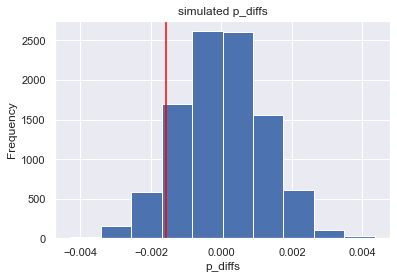

In [116]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('simulated p_diffs');
plt.axvline(obs_diff,color='red')


 proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

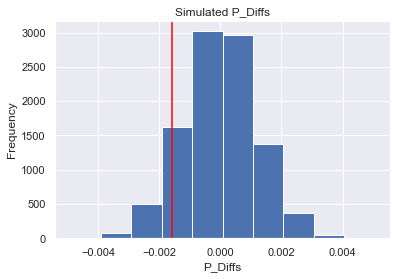

In [120]:
Null_Values= np.random.normal(0,np.std(p_diffs),len(p_diffs))
plt.hist(Null_Values)
plt.xlabel('P_Diffs')
plt.ylabel('Frequency')
plt.title('Simulated P_Diffs');
plt.axvline(obs_diff,color='red')



 - What is this value called in scientific studies?  
    - Answer : The value is called P-Value.
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?
    - there is a difference between the new and old pages P-Value > Type I error rate (0.05) So we fail to reject the null hypothesis, so that the control page has higher probability of convert rate than treatment page.




- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [121]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()

# number of conversions with the new_page
convert_old =df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

# number of individuals who were shown the old_page
n_old =df2.query('landing_page == "old_page"')['user_id'].nunique()


# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
convert_new,convert_old,n_new,n_old

(17264, 17489, 145310, 145274)

In [122]:
import statsmodels.api as sm

# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


- the z-score of 1.3109241984234394  <  1.6448536269514722  , we fail to reject the null hypothesis 
-  in j and k it suggests there is no significant difference between old page and new page conversions


<a id='regression'></a>
### Part III - A regression approach

 Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

- Logistic regression: is  predicts categorical responses when there are only two possible outcomes.
- We have 2 posible outcomes (converted, not converted) ,so the type of of regression should we be performing in this case is Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [123]:
import statsmodels.api as sm
# ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


 regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [124]:
Log_Mod= sm.Logit(df2['converted'],df2[['intercept','ab_page']])

Resualt = Log_Mod.fit()
Resualt.params

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


intercept   -1.988777
ab_page     -0.014989
dtype: float64

 Provide the summary of your model below, and use it as necessary to answer the following questions.

In [125]:
Resualt.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-16 19:40 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

- the p-value associated with ab_page is 1.9888 , P-Value > Type I error rate (0.05) this mean 
-  differ from the value you found in Part II
    - p-value in Part II the null and alternative hypotheses :
        - Null hypothese is **$H_0$**: **$p_{old}$** >= **$p_{new}$**
        - Alternative  hypothese is **$H_1$**: **$p_{old}$** < **$p_{new}$**     
    - p-value in Part III the null and alternative regression model :
        - Null hypothese is **$H_0$**: **$p_{old}$** - **$p_{new}$** =0
        - Alternative  hypothese is **$H_1$**: **$p_{old}$** - **$p_{new}$** !=0
        

now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- yes there is other things that might influence whether or not an individual converts
- Disadvantages to adding additional terms into your regression model:
    - using incomplete data 
    - falsely concluding that a correlation is a causation.

In [126]:
# Read the countries.csv
countries_df= pd.read_csv('countries.csv')
print(countries_df.head())
countries_df['country'].value_counts()

   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [127]:
# Join with the df2 dataframe
df_merged=df2.merge(countries_df,on='user_id',how='left')
df_merged.head()



,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [128]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [129]:
# Fit your model, and summarize the results
#Create intercept variable
df_merged['intercept'] = 1
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
Result = logit_mod.fit()
Result.params


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


intercept   -2.030029
ab_page     -0.014943
UK           0.050640
US           0.040757
dtype: float64

In [130]:
Result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-16 19:41 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
    - the  ab_page p-value associated is 0.1912	 , P-Value > Type I error rate (0.05)
    - the  UK p-value associated is 0.0745 , P-Value > Type I error rate (0.05)
    - the  Us p-value associated is 0.1295 , P-Value > Type I error rate (0.05)
    - For each unit for new_page decrease convert will be 1.5% more likely to happen, when all other varible constant
    - For each unit for UK decrease convert will be 5% more likely to happen, when all other varible constant
    - For each unit for US	 decrease convert will be 4% more likely to happen, when all other varible constant



In [131]:

df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page'] 

df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page'] 

logit3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
print(results.params)
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
intercept    -1.986478
ab_page      -0.020564
UK           -0.005744
CA           -0.017528
UK_ab_page    0.031398
CA_ab_page   -0.046885
dtype: float64


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-16 19:41 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
    - the  ab_page p-value associated is 0.1323 , P-Value > Type I error rate (0.05)
    - the  UK p-value associated is 0.7598 , P-Value > Type I error rate (0.05)
    - the  CA p-value associated is 0.6418 , P-Value > Type I error rate (0.05)
    - the  UK_ab_page p-value associated is 0.2377 , P-Value > Type I error rate (0.05)
    - the  CA_ab_page p-value associated is 0.3833 , P-Value > Type I error rate (0.05)
- Can you reject/fail to reject the null hypotheses (regression model)?
    - yes we fail to reject the null hypotheses
- Comment on the effect of page and country to predict the conversion.
    - The country do not appear to impact conversions.


# Conclusion
>* #### After tests the three different tests, we came to the same result in all three, which is to keep the old page and not change it with the new page. As there is insufficient evidence to say that the new page conversion rate is higher than the old page conversion rate, and there is also no evidence that countries are affected by the conversion rate.
>* #### It is better for the developer teams to design another new page or improve the old one. 

